In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 
from math import floor

def apply_over_img(img, f):
    new_img = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img[i][j] = f(img, i, j)
    return new_img

def kernel_apply(img, i, j, kernel, accumulator = np.array([0, 0, 0]), accumulate = lambda x, y: x + y):    
    sum = accumulator
    for ii in range(kernel.shape[0]):
        for jj in range(kernel.shape[1]):
            i_ = clamp(i + floor(ii - kernel.shape[0] / 2), 0, img.shape[0] - 1)
            j_ = clamp(j + floor(jj - kernel.shape[1] / 2), 0, img.shape[1] - 1)
            sum = accumulate(sum, img[i_][j_] * kernel[ii][jj])
    return sum

def clamp(val, min, max):
    if val < min: return min
    if val > max: return max
    return val

def display(img):
    plt.imshow(img)
    plt.show()
def write(path, img):
    img_copy = img.copy()
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
    cv2.imwrite(path, img_copy)
    

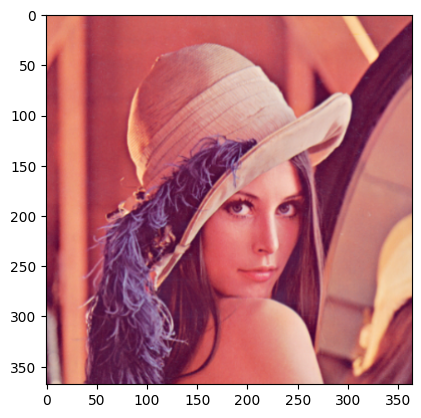

In [2]:
image = cv2.imread('LenaForsen.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
write("output/0.original.jpg", image)
display(image)
plt.show()

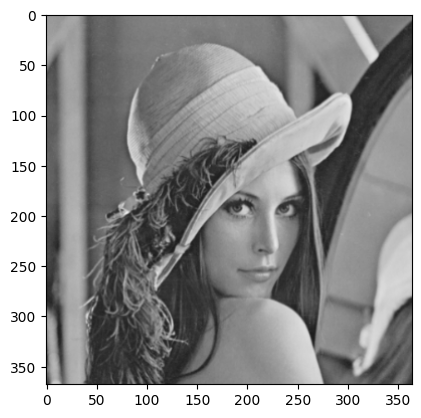

In [3]:
def gray(img, i, j):
    pixel = img[i][j]
    gray = 0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2]
    return np.array([gray, gray, gray])

gray_img = apply_over_img(image, gray)
display(gray_img)
write("output/1.1.gray.jpg", gray_img)


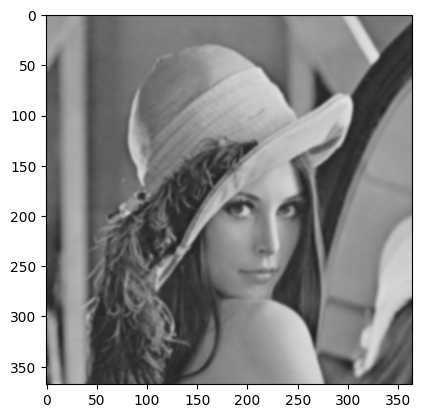

In [4]:
def blur3x3(img, i, j):
    gaussian = np.array([
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]
    ]) / 16
    return kernel_apply(img, i, j, gaussian)

def blur5x5(img, i, j):
    gaussian = np.array([
        [1,  4,  6,  4, 1],
        [4, 16, 24, 16, 4],
        [6, 24, 36, 24, 6],
        [4, 16, 24, 16, 4],
        [1,  4,  6,  4, 1]
    ]) / 256
    return kernel_apply(img, i, j, gaussian)


blur_img = apply_over_img(gray_img, blur5x5)
display(blur_img)
write("output/1.2.blur5x5.jpg", blur_img)


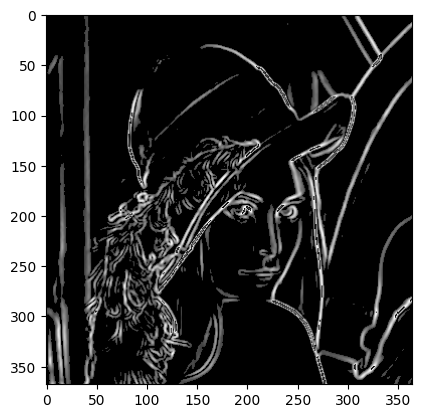

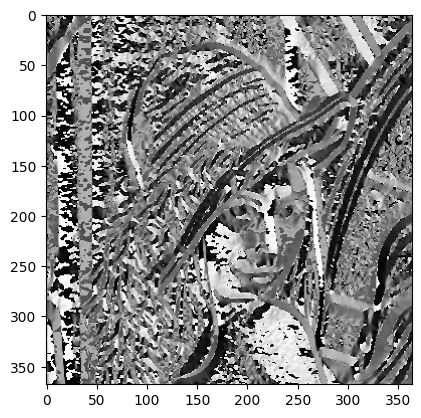

In [5]:
def sobel(img, i, j):
    sobel_x = np.array([
        [-1, 0, 1], 
        [-2, 0, 2], 
        [-1, 0, 1]], 
        np.float32)
    
    sobel_y = np.array([
        [-1, -2, -1], 
        [ 0,  0,  0], 
        [ 1,  2,  1]], 
        np.float32)
    
    sobel_grad_x = kernel_apply(img, i, j, sobel_x) / 255
    sobel_grad_y = kernel_apply(img, i, j, sobel_y) / 255
    sobel_grad_ = np.sqrt(sobel_grad_x**2 + sobel_grad_y**2) * 255
    
    threshold = 64
    
    sobel_dir_ = np.arctan2(sobel_grad_y, sobel_grad_x) * 180 / np.pi
    
    sobel_grad_[sobel_grad_ < threshold] = 0
    
    return sobel_dir_, sobel_grad_

def sobel_dir(img, i, j):
    dir, _ = sobel(img, i, j)
    return dir
def sobel_img(img, i, j):
    _, img = sobel(img, i, j)
    return img

sobel_grad_ = apply_over_img(blur_img, sobel_img)
display(sobel_grad_)
write("output/1.3.sobel_img.jpg", sobel_grad_)

sobel_dir_ = apply_over_img(blur_img, sobel_dir)
display(sobel_dir_)
write("output/1.3.sobel_dir.jpg", sobel_dir_)

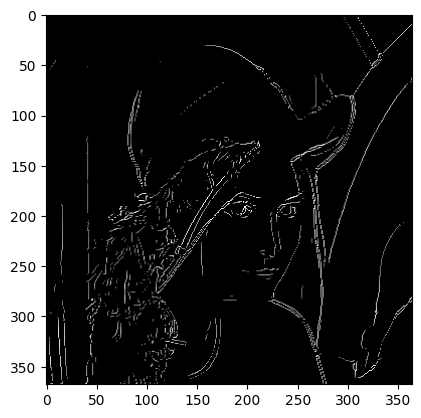

True

In [6]:
def nonmaxima_supression(img, i, j):
    global sobel_grad_
    global sobel_dir_
    
    suppressed = sobel_grad_[i][j][0]
    # Get the sobel_dir_ of the sobel_grad_ at the pixel
    angle = sobel_dir_[i, j, 0]

    # Check if the sobel_grad_ at the pixel is a local maximum
    # in the sobel_dir_ of the sobel_grad_
    if angle < 45:
        if j > 0 and sobel_grad_[i, j, 0] < sobel_grad_[i, j-1, 0] or \
            j < img.shape[1] - 1 and sobel_grad_[i, j, 0] < sobel_grad_[i, j+1, 0]:
            suppressed = 0
    elif angle < 90:
        if i > 0 and j < img.shape[1] - 1 and sobel_grad_[i, j, 0] < sobel_grad_[i-1, j+1, 0] or \
            i < img.shape[0] - 1 and j > 0 and sobel_grad_[i, j, 0] < sobel_grad_[i+1, j-1, 0]:
            suppressed = 0
    elif angle < 135:
        if i > 0 and sobel_grad_[i, j, 0] < sobel_grad_[i-1, j, 0] or \
            i < img.shape[0] - 1 and sobel_grad_[i, j, 0] < sobel_grad_[i+1, j, 0]:
            suppressed = 0
    else:
        if i > 0 and j > 0 and sobel_grad_[i, j, 0] < sobel_grad_[i-1, j-1, 0] or \
            i < img.shape[0] - 1 and j < img.shape[1] - 1 and sobel_grad_[i, j, 0] < sobel_grad_[i+1, j+1, 0]:
            suppressed = 0
    
    max_threshold = 100
    min_threshold = 64
    
    if suppressed < max_threshold:
        suppressed = 50
    if suppressed < min_threshold:
        suppressed = 0
    
    return suppressed



suppressed = apply_over_img(sobel_grad_, nonmaxima_supression)
display(suppressed)
cv2.imwrite("output/1.4.suppressed.jpg", suppressed)



5.147098380057916


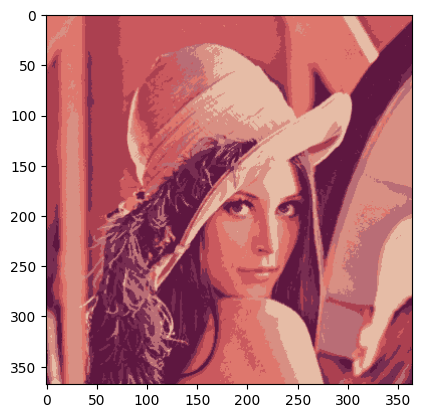

In [18]:
simplified = image.copy()

# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=3, n_init = 'auto', init='random')
# kmeans.fit(simplified.copy().reshape((image.shape[0] * image.shape[1], 3)))

# def simplify(img, i, j):
#     global kmeans    
#     idx = kmeans.predict(np.array([img[i][j]]))[0]
#     return kmeans.cluster_centers_[idx]

from IPython.display import clear_output


class KMeans:
    
    def compute_centroid(l):
        return np.mean(l, axis=0)
    
    def recompute_centroids(clusters):
        centroids = []
        for idx, cluster in enumerate(clusters):
            centroids.append(KMeans.compute_centroid(cluster)) 
        return centroids
    
    
    def fit(self, arr, n_clusters):
        clusters = [arr[i : min(i + len(arr) // n_clusters, len(arr) - 1)] for i in range(0, len(arr), len(arr) // n_clusters + 1)]
        
        old_centroids = [np.array([0, 0, 0]) for _ in range(n_clusters)]
        self.centroids = KMeans.recompute_centroids(clusters)
        
        err = sum(map(np.linalg.norm, np.array(old_centroids) - np.array(self.centroids)))
        while err > 5:
            clusters = [[] for _ in range(n_clusters)]
            
            clear_output(wait=True); print(err)
            
            for val in arr:
                distances = sorted([(idx, D) for idx, D in enumerate(list(map(lambda x: np.linalg.norm(val - x), self.centroids)))], key=lambda x: x[1])
                
                # print(distances)
                
                for (idx, _) in distances:
                    if clusters[idx].__len__() < (len(arr) + 1) // n_clusters:
                        clusters[idx].append(val)
                        break
            
            old_centroids = self.centroids
            self.centroids = KMeans.recompute_centroids(clusters)
            err = sum(map(np.linalg.norm, np.array(old_centroids) - np.array(self.centroids)))

        return self
    
    def predict(self, val):
        minD = 99999999999999
        centroid = self.centroids[0]
        
        val = np.array(val[0])
        
        for centroid_ in self.centroids:
            centroid_ = np.array(centroid_)
            D = np.linalg.norm(val - centroid_)
            if D < minD:
                minD = D
                centroid = centroid_

        return centroid


kmeans = KMeans().fit(simplified.copy().reshape((image.shape[0] * image.shape[1], 3)), 8)

def simplify(img, i, j):
    global kmeans    
    return kmeans.predict(np.array([img[i][j]]))

simplified = apply_over_img(image, simplify)
display(simplified)
write("output/2.1.simplified.jpg", simplified)

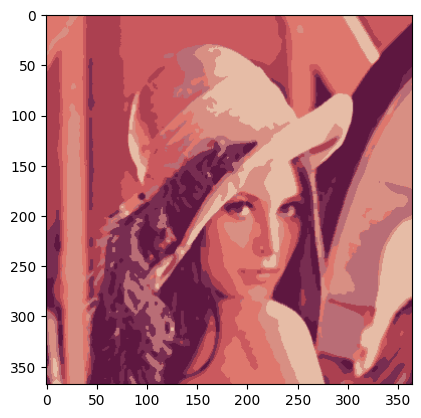

In [19]:
def median(img, i, j):
    kernel = np.array([
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]
    ])
    l1 = kernel_apply(img, i, j, kernel, [], lambda x, y : x + [y])
    l2 = []
    for pixel in l1:
        l2.append(0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2])
    l_ = list(zip(l2, l1))
    l_.sort(key=lambda x: x[0])
    return l_[len(l_) // 2 + len(l_) % 2][1]


median_ = apply_over_img(simplified, median)
display(median_)
write("output/2.2.median.jpg", median_)


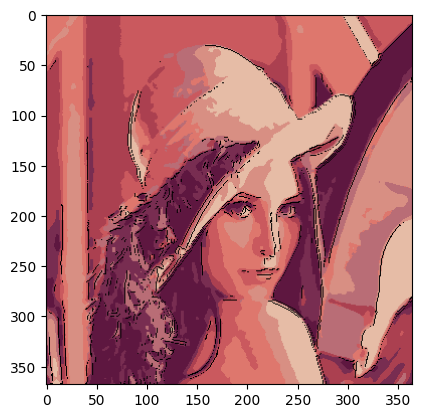

In [20]:
def add(img, i, j):
    global median_
    global suppressed
    
    if suppressed[i][j][0] <= 0.9: # TODO
        return median_[i][j]
    return np.array([0, 0, 0])

result = apply_over_img(median_, add)
display(result)
write("output/3.sum.jpg", result)
